# Notebook configuration

In [1]:
run_number    = 6283
save_plots    = True
plots_format  = "pdf"
outputfolder  = "plots/{0}/".format(run_number)

# It's mandatory to have path sctructure as: /what/ever/this/path/is/RUN_NUMBER/ and just the files you want to
# use in this folder. If it's not the case, you should implement proper changes
input_path    = "/Users/brais/Documents/NEXT/Datos/Kr_lt/{0}_joint/".format(run_number)

correction_filename = "/Users/brais/Documents/NEXT/Datos/Correction_maps/corrections_run6198.h5"

output_dir  = "/Users/brais/Documents/NEXT/Datos/Kr_lt/{0}_/".format(run_number)
output_file = output_dir + "Time_evolution_{0}.h5".format(run_number)

Zrange        =     0, 600
XYrange       =  -180, 180
Rrange        =     0, max(XYrange)
Erange_raw    =   3e3, 15e3

E0guess       = 12.5e3
Ltguess       = 2200
R_fiducial    = 100
Z_fiducial    = 10 , 570
Zrange_DV     = 500, 600
nslices       = 20
nsigmas       = 5
nStimeprofile = 1800



In [2]:
import os
import glob
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt
import pandas            as pd
from   matplotlib.colors import LogNorm
import matplotlib.dates  as md
import datetime

from copy import copy

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.corrections    as corrf
import invisible_cities.io  .dst_io         as dstio
import invisible_cities.reco.dst_functions  as dstf

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import labels
from invisible_cities.icaro.hst_functions import shift_to_bin_centers
from invisible_cities.core.stat_functions import poisson_sigma
from invisible_cities.icaro.hst_functions import resolution
from invisible_cities.icaro.hst_functions import display_matrix
from invisible_cities.core.stat_functions import poisson_sigma

from invisible_cities.icaro.hst_functions import plot_writer

pi   = np.pi
save = plot_writer(outputfolder, plots_format) if save_plots else lambda *x: None


XYcorrection = dstf.load_xy_corrections(correction_filename,
                                        group         =  "XYcorrections",
                                        node          =  "Egeometry",
                                        norm_strategy =  "index",
                                        norm_opts     = {"index": (40, 40)})

Running on  Tue Aug 14 15:41:45 2018


### General ploting options

In [3]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 16, 12
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

# Useful functions

In [4]:
def z_slice(data, Zrange=[0,550], nZbins=50, range_fit=[9e3,14e3], 
            seed_gauss_z0=[1e4, 12e3, 200], seed_lt=[13e3, 2200]):
    
    E0guess, Ltguess = seed_lt
    
    Zbins   = np.linspace(*Zrange, nZbins+1)
    Zcorr   = corrf.LifetimeCorrection(-Ltguess, E0guess)
    Z_drift = []
    sigma   = []
    
    for i in range(len(Zbins)-1):
        zpos    = np.mean([Zbins[i], Zbins[i+1]])
        data_   = data[coref.in_range(data.Z.values, Zbins[i], Zbins[i+1])]
        E_zcorr = data_.S2e.values 
        
        y, x    = np.histogram(E_zcorr, 50, range=range_fit)
        x       = shift_to_bin_centers(x)
        seed    = seed_gauss_z0
        seed[1] = E0guess*Zcorr(zpos).value
        f    = fitf.fit(fitf.gauss, x, y, seed, fit_range=range_fit)
        Z_drift.append([f.values[1],f.errors[1]])
        sigma  .append([f.values[2],f.errors[2]])

    
    Zbins, Z_E_mean, u_Z_E_mean, sigma, u_sigma = map(np.array, [Zbins, *zip(*Z_drift), *zip(*sigma)])
    Zbins = shift_to_bin_centers(Zbins)
    return(Zbins, Z_E_mean, u_Z_E_mean, sigma, u_sigma)


def slice_and_fit(data, Zrange=[0,550], nZbins=50, range_fit=[11e3,16e3],
                  seed_gauss_z0=[1e4, 12e3, 200], seed_lt=[13e3, 2200]):
    
    Zbins, Z_E_mean, u_Z_E_mean, sigma, u_sigma = z_slice(data, Zrange, nZbins, range_fit, seed_gauss_z0, seed_lt)
    
    

# Read data

In [5]:
files = glob.glob(input_path + '*h5')
key   = os.path.getmtime
#files = sorted(files, key=key)[:100]

In [6]:
full = dstio.load_dsts(files, "DST", "Events")
full = full[full.R<max(Rrange)] # soft radial cut to reduce badly reconstructed events
full = full[full.nS1==1]
full = full[full.nS2==1]
print(len(full))
full.head()

1427950


,index,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
0,0,1,1.534151e+09,0,0,1,1,225.0,2.474571,12.380002,...,19,456.942902,456.942902,2.133692,107.464885,121.378112,162.115229,0.846122,14.992314,16.468374
1,1,2,1.534151e+09,0,0,1,1,250.0,1.047213,7.716753,...,22,308.458893,308.458893,1.746970,-23.876764,29.364148,37.846440,2.253490,21.512177,15.305197
7,7,6,1.534151e+09,0,0,1,1,300.0,3.169879,15.620178,...,25,541.850159,541.850159,2.401680,-140.493942,-77.263182,160.337604,-2.638796,10.496857,11.773090
10,10,8,1.534151e+09,0,0,1,1,250.0,2.901912,16.044729,...,20,431.569641,431.569641,2.118157,-57.049409,-158.751078,168.690663,-1.915789,9.474248,10.438245
11,11,12,1.534151e+09,0,0,1,1,150.0,1.885390,8.823835,...,20,456.833832,456.833832,2.019272,-130.943897,98.033577,163.575324,2.498944,13.769985,12.459387


### Event distribution 

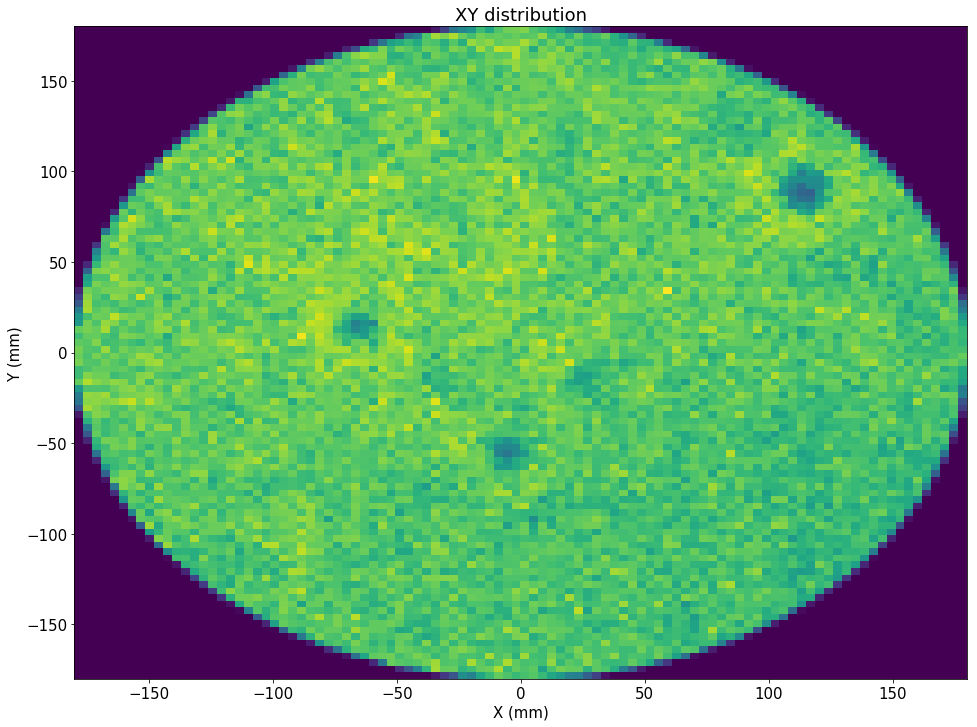

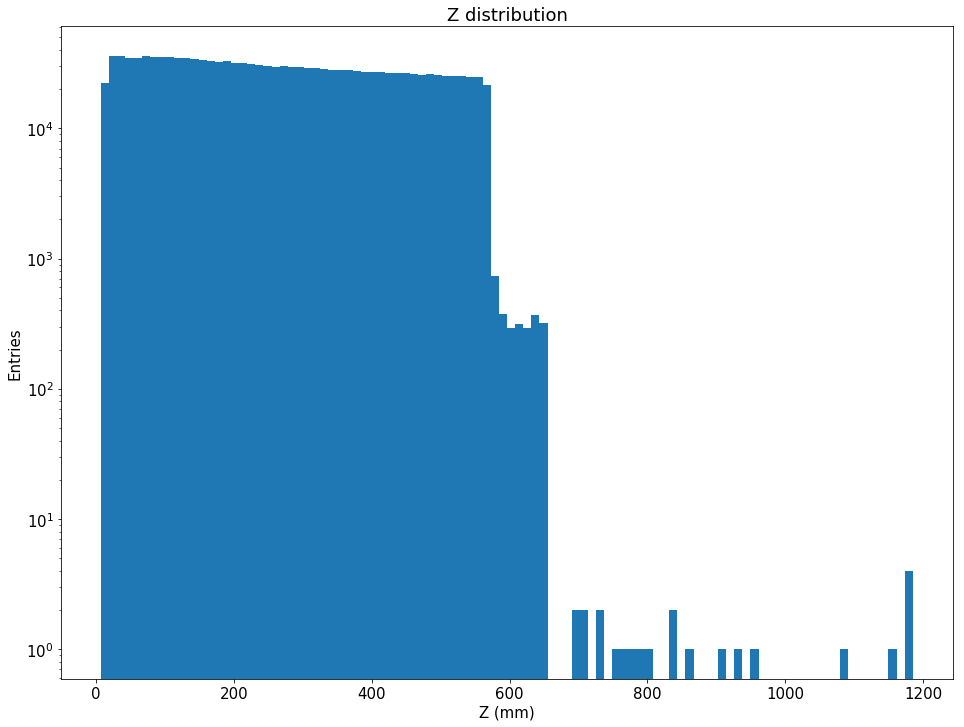

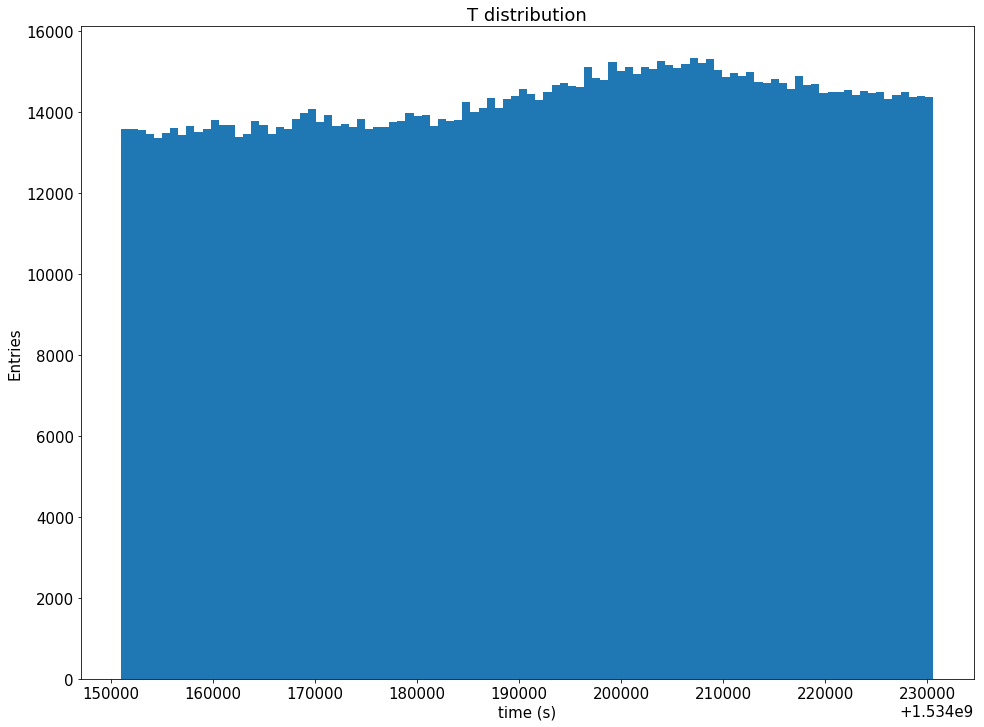

In [7]:
hist2d(full.X, full.Y, (100,100), range=[XYrange,XYrange])
labels("X (mm)", "Y (mm)", "XY distribution")
save("Raw_XY")

hist(full.Z, 100)
plt.yscale('log')
labels("Z (mm)", "Entries", "Z distribution")
save("Raw_Z")

hist(full.time, 100)
labels("time (s)", "Entries", "T distribution")
save("Raw_t")

### Some S1 and s2 plots

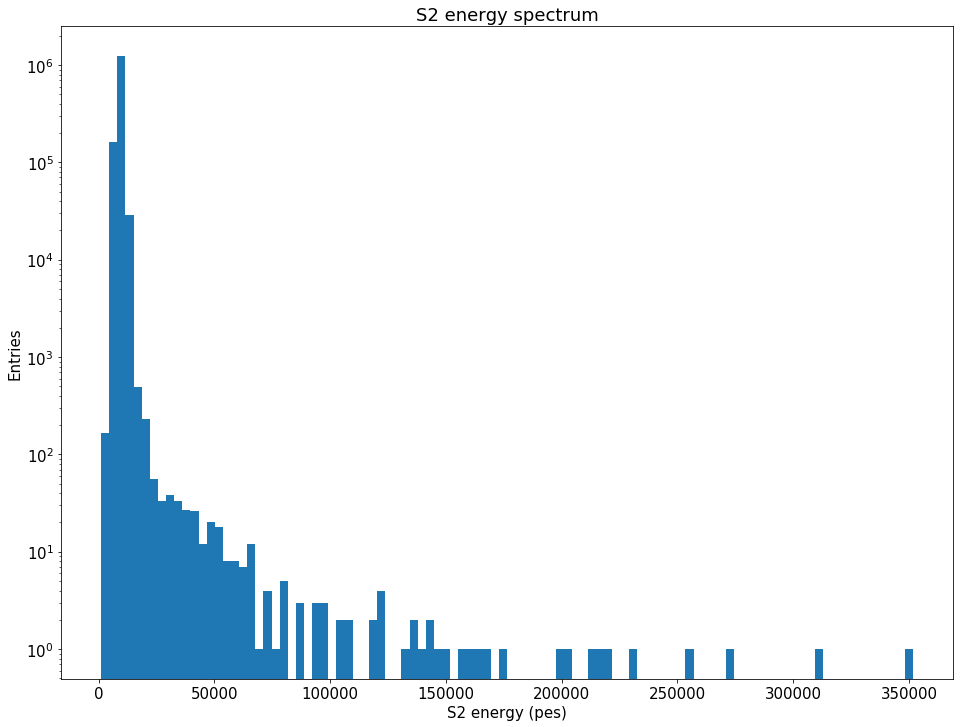

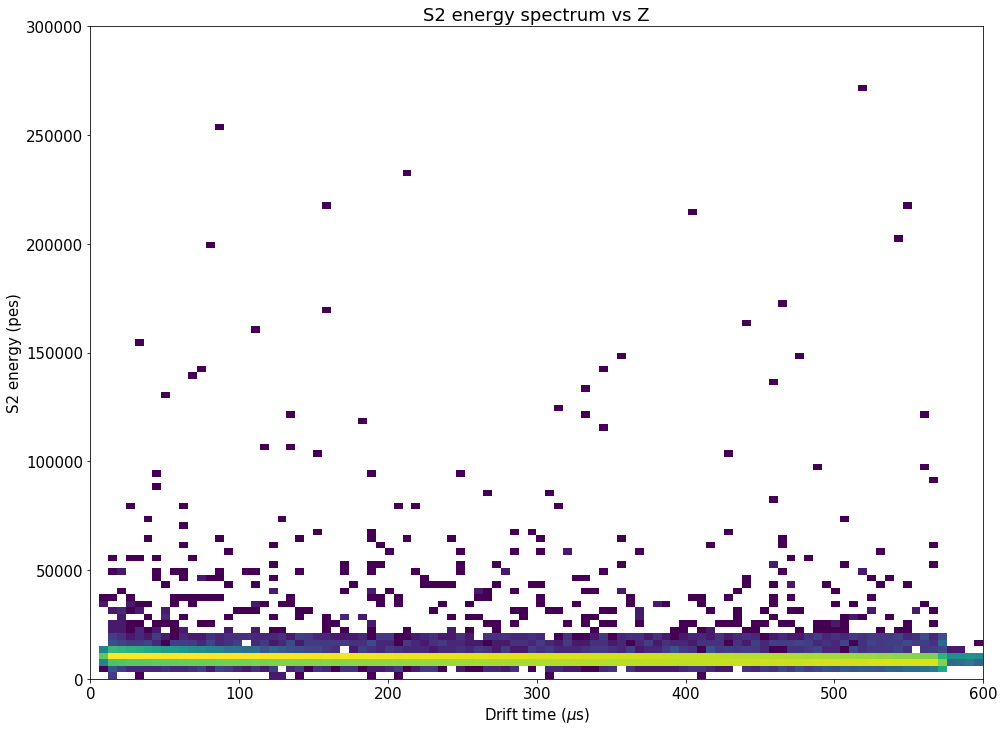

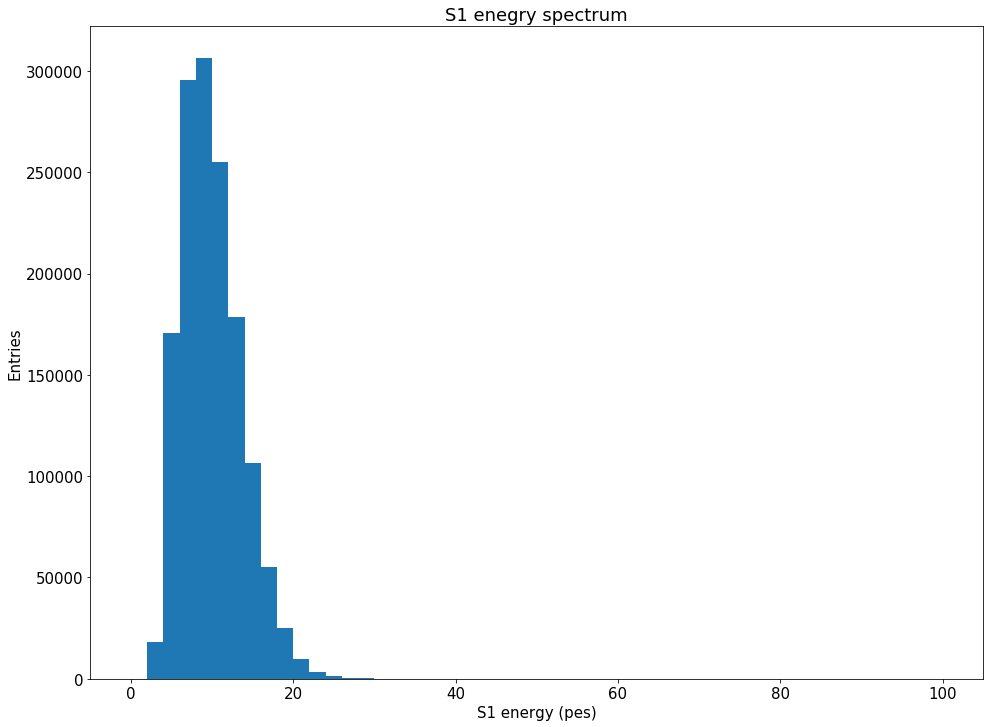

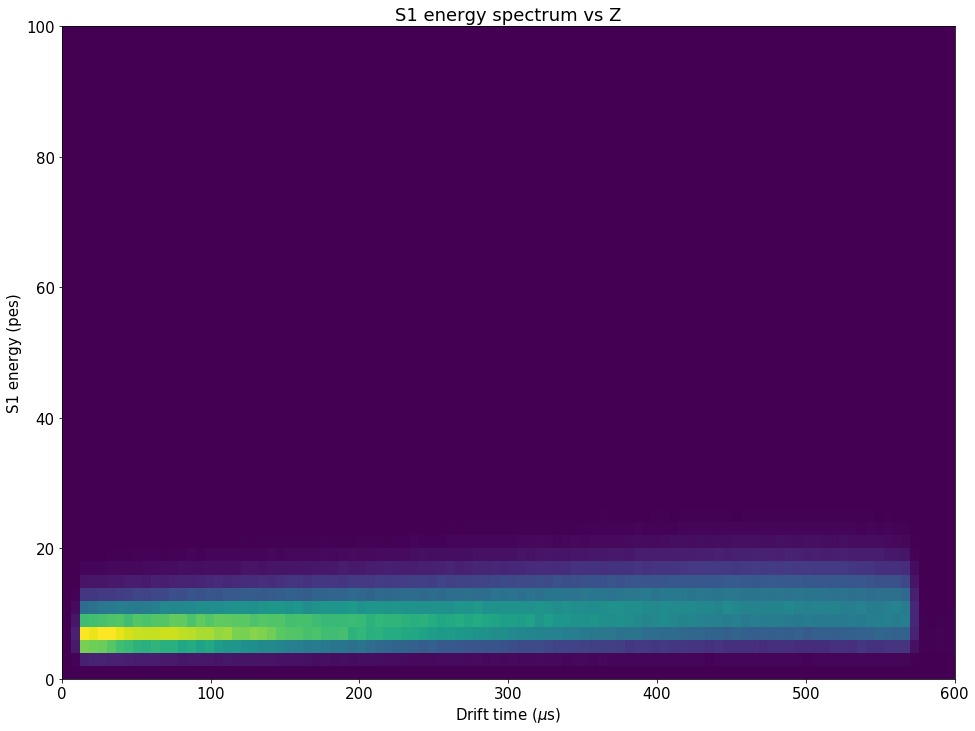

In [8]:
hist(full.S2e, 100)
plt.yscale('log')
labels("S2 energy (pes)", "Entries", "S2 energy spectrum")
save("Raw_S2_energy")


hist2d(full.Z, full.S2e, (100, 100), range=(Zrange, [0,0.3e6]), norm=LogNorm())
labels("Drift time ($\mu$s)", "S2 energy (pes)", "S2 energy spectrum vs Z")
save("Raw_S2_energy_vsZ")

hist(full.S1e, 50, range=[0,100])
labels("S1 energy (pes)", "Entries", "S1 enegry spectrum")
save("Raw_S1_energy")


hist2d(full.Z, full.S1e, (100, 50), range=(Zrange, [0,100]))
labels("Drift time ($\mu$s)", "S1 energy (pes)", "S1 energy spectrum vs Z")
save("Raw_S1_energy_vsZ")


## Kr selection

In [9]:
fid = full
fid = fid[fid.R < R_fiducial] # Fiducialize in order to reduce geometrical effects
print("Ratio:", len(fid)/len(full))
fid.head()

Ratio: 0.31423649287440036


,index,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
1,1,2,1.534151e+09,0,0,1,1,250.0,1.047213,7.716753,...,22,308.458893,308.458893,1.746970,-23.876764,29.364148,37.846440,2.253490,21.512177,15.305197
18,18,21,1.534151e+09,0,0,1,1,100.0,1.158626,4.199605,...,16,92.160065,92.160065,0.987955,93.171079,-12.840297,94.051705,-0.136952,13.121380,12.278386
21,21,24,1.534151e+09,0,0,1,1,150.0,0.674311,4.099269,...,15,556.311768,556.311768,2.331071,50.657338,8.074159,51.296763,0.158058,8.185552,9.465299
24,24,28,1.534151e+09,0,0,1,1,125.0,2.547075,10.080960,...,23,495.293884,495.293884,2.189372,-1.542409,64.303581,64.322077,1.594778,16.994364,12.409481
26,26,30,1.534151e+09,0,0,1,1,225.0,1.202170,9.372906,...,24,458.868713,458.868713,2.077129,-34.362475,48.358484,59.323879,2.188586,23.594347,19.098617


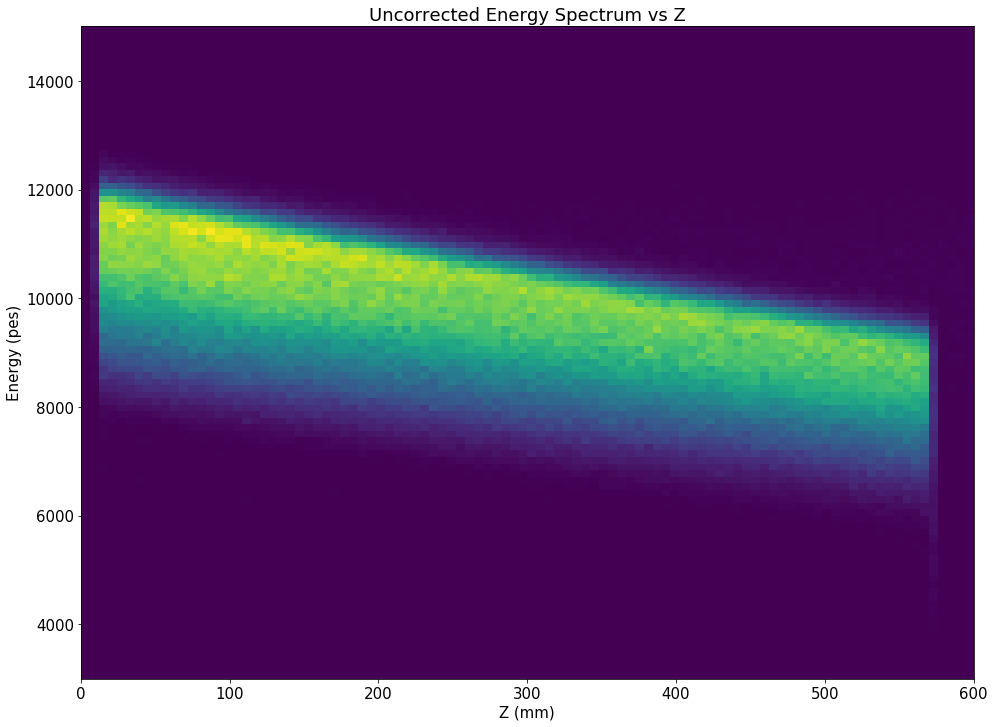

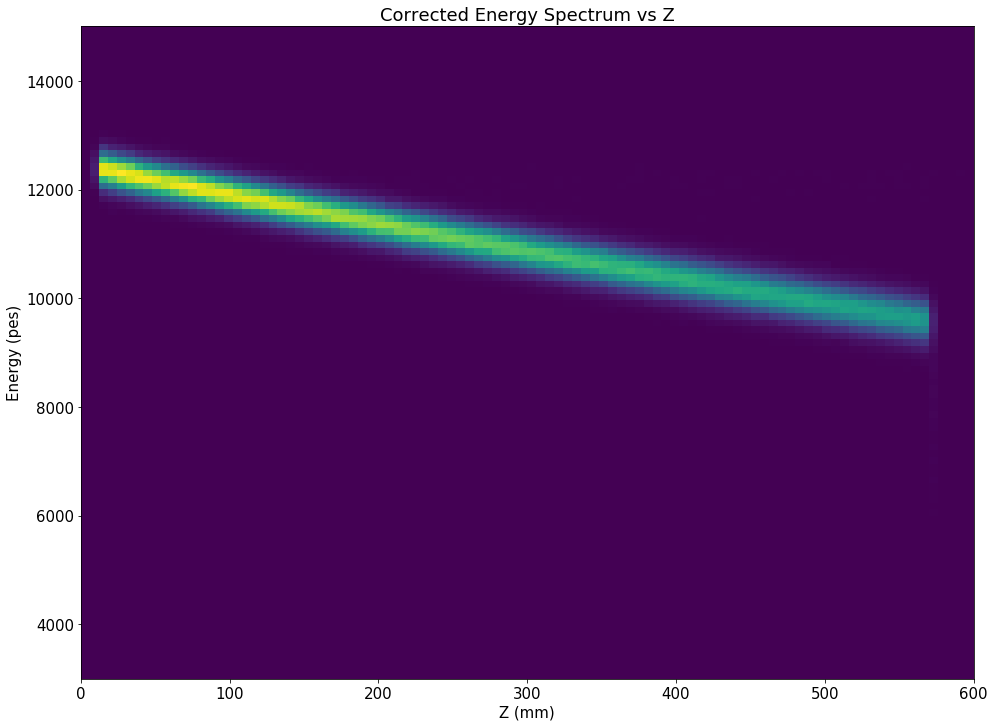

In [10]:
data = full

hist2d(data.Z, data.S2e, (100, 100), range=(Zrange, Erange_raw));#,  norm=LogNorm());
labels("Z (mm)", "Energy (pes)", "Uncorrected Energy Spectrum vs Z")

Ecorr = data.S2e * XYcorrection(data.X.values, data.Y.values).value
hist2d(data.Z, Ecorr, (100, 100), range=(Zrange, Erange_raw));#,  norm=LogNorm());
labels("Z (mm)", "Energy (pes)", "Corrected Energy Spectrum vs Z")


## Data Selection

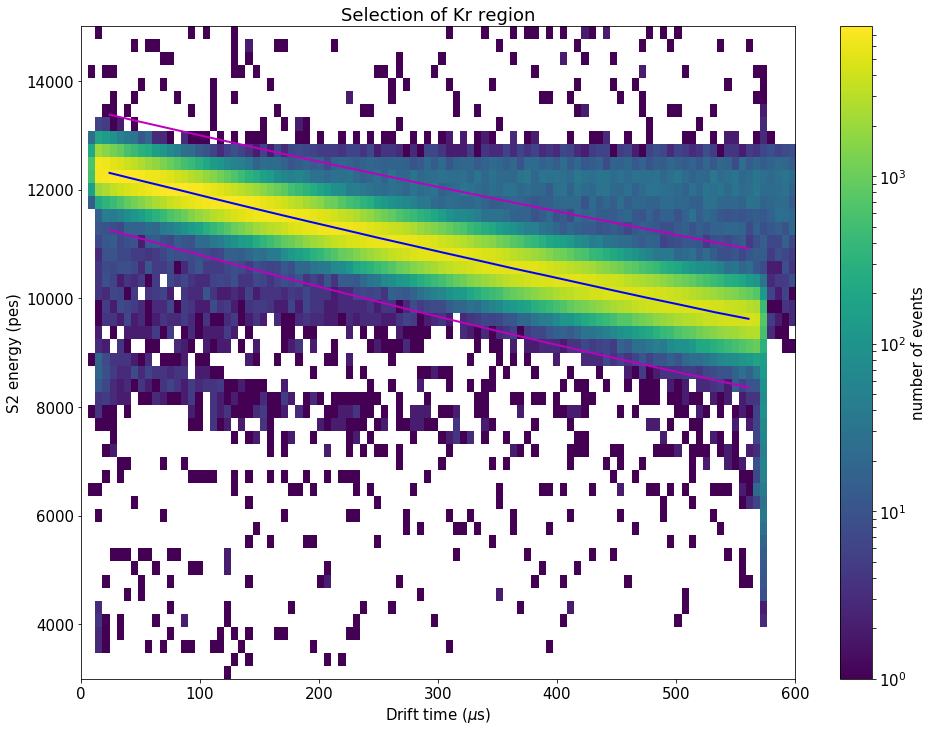

In [11]:
data = copy(full)#[:]

Ecorr = data.S2e * XYcorrection(data.X.values, data.Y.values).value
data.S2e = Ecorr

plt.hist2d(data.Z, Ecorr, (100, 50), range=(Zrange, Erange_raw),  norm=LogNorm())
plt.colorbar().set_label("number of events")
Zbins, Z_E_mean, u_Z_E_mean, sigma, u_sigma = z_slice(data, [10,575], nslices, [9e3, 14e3], 
                                                      [1e6,12e3,200], [12e3,1500])


plt.errorbar(Zbins, Z_E_mean, yerr=u_Z_E_mean, fmt='b', linewidth=2)



lowE_fit  = fitf.fit(fitf.expo, Zbins, Z_E_mean-nsigmas*sigma, [12e3,-2000], sigma=u_Z_E_mean)
highE_fit = fitf.fit(fitf.expo, Zbins, Z_E_mean+nsigmas*sigma, [12e3,-2000], sigma=u_Z_E_mean)

lowE_cut  =  lowE_fit.fn
highE_cut = highE_fit.fn

plt.plot    (Zbins,  lowE_cut(Zbins),  "m", lw=2, label="$\pm 5 \sigma$ region")
plt.plot    (Zbins, highE_cut(Zbins),  "m", lw=2)

labels("Drift time ($\mu$s)", "S2 energy (pes)", "Selection of Kr region")
save("Selection_of_Kr_region")


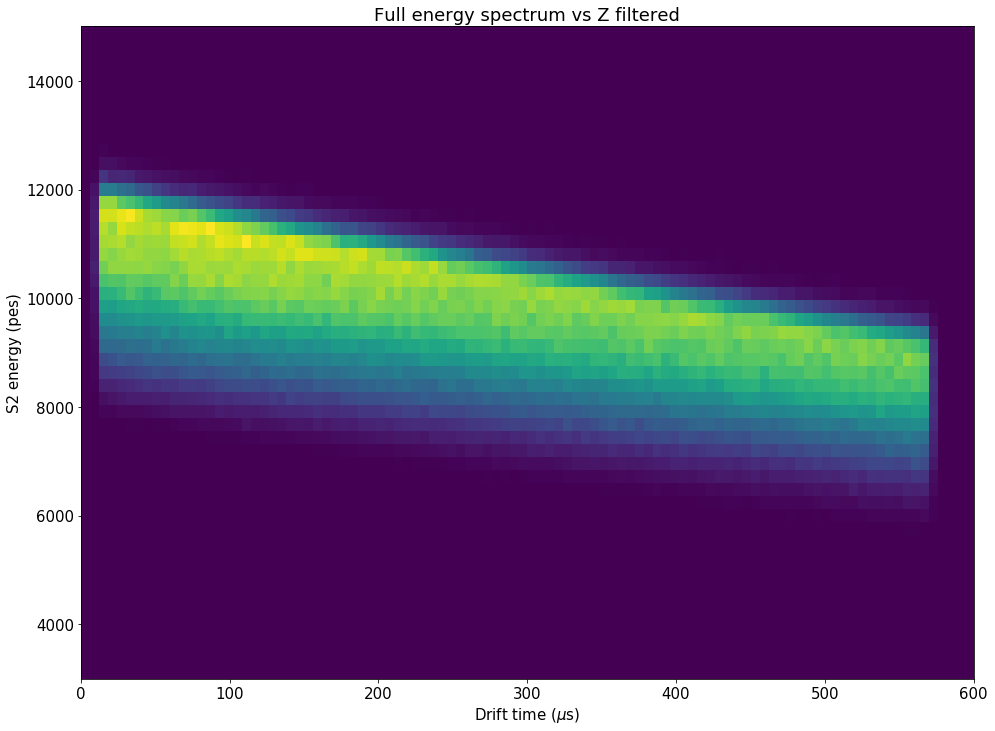

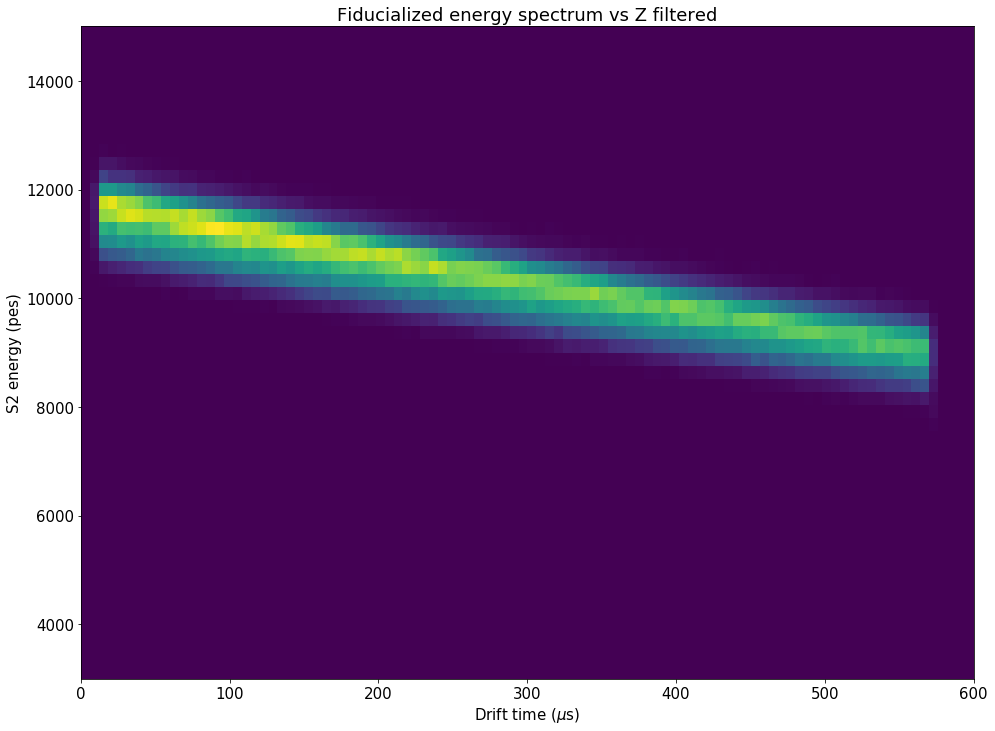

In [12]:
full_filtered = full[coref.in_range(full.S2e * XYcorrection(full.X.values, full.Y.values).value,
                                    lowE_cut(full.Z.values), highE_cut(full.Z.values))]
fid_filtered  = fid [coref.in_range(fid .S2e * XYcorrection(fid .X.values, fid .Y.values).value, 
                                    lowE_cut(fid .Z.values), highE_cut(fid .Z.values))]

hist2d(full_filtered.Z, full_filtered.S2e, (100, 50), range=(Zrange, Erange_raw));
labels("Drift time ($\mu$s)", "S2 energy (pes)", "Full energy spectrum vs Z filtered")
save("Raw_energy_vsZ_fullfiltered")

hist2d(fid_filtered.Z, fid_filtered.S2e, (100, 50), range=(Zrange, Erange_raw));
labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z filtered")
save("Raw_energy_vsZ_fid_filtered")

## General plots after filtering

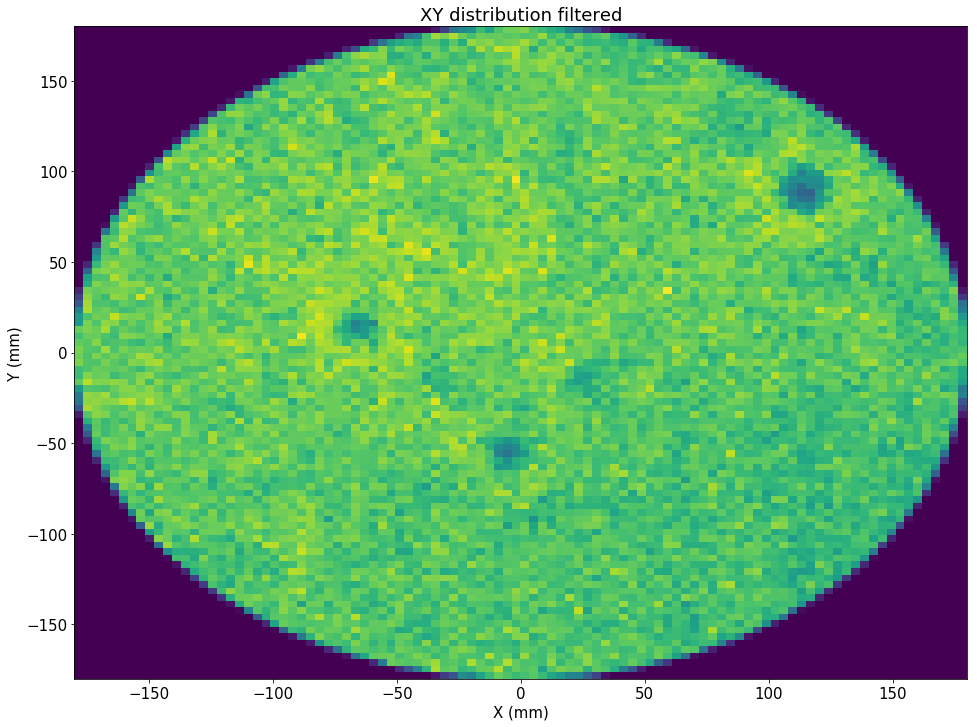

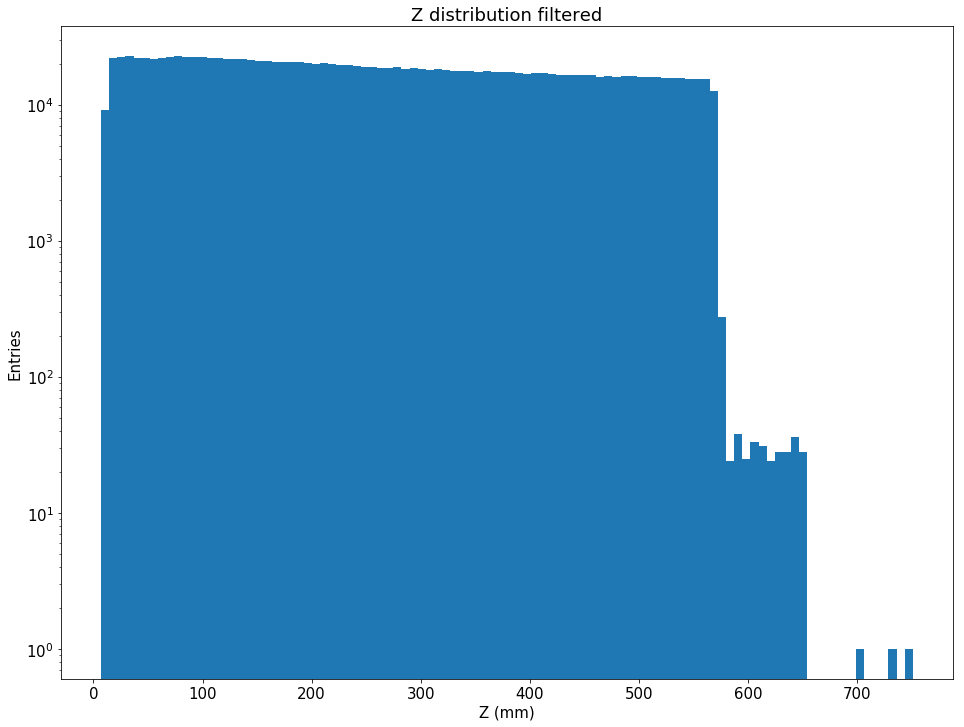

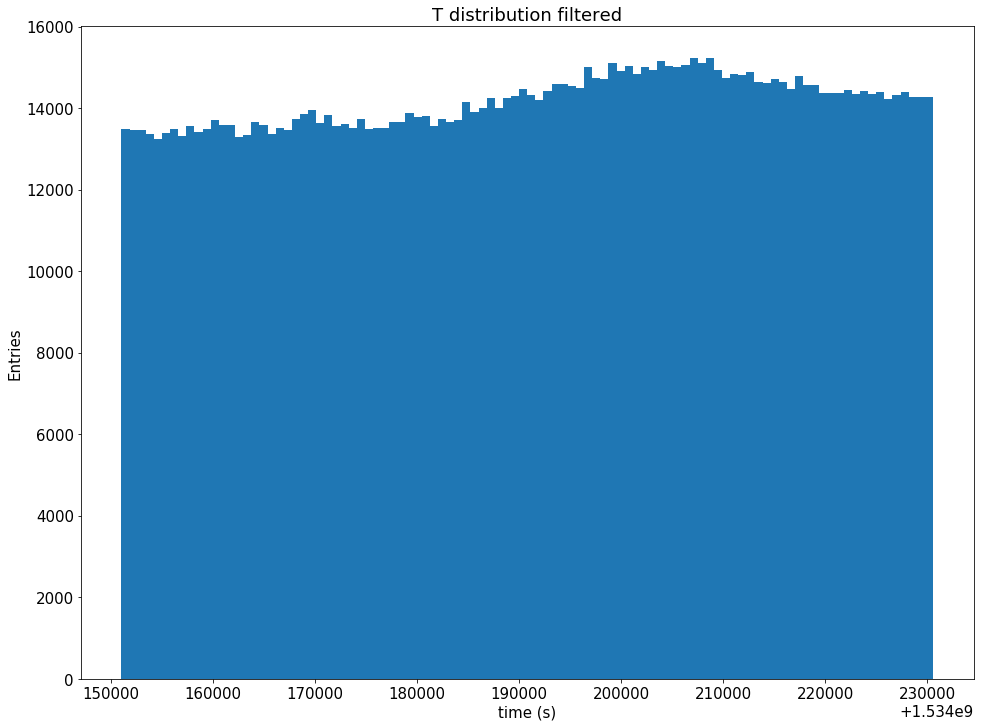

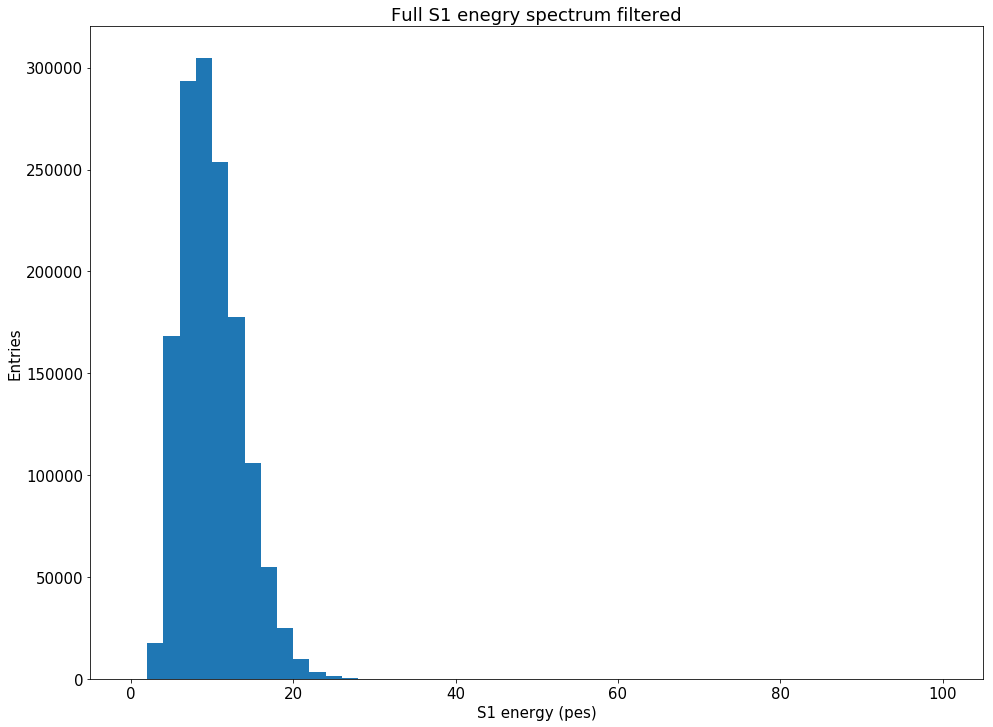

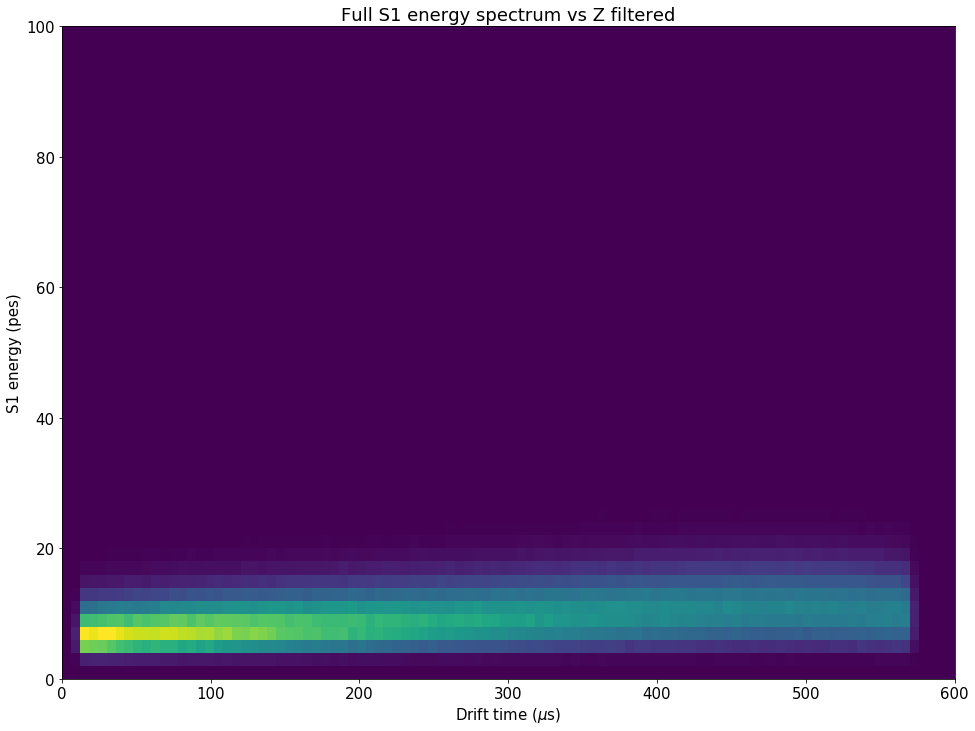

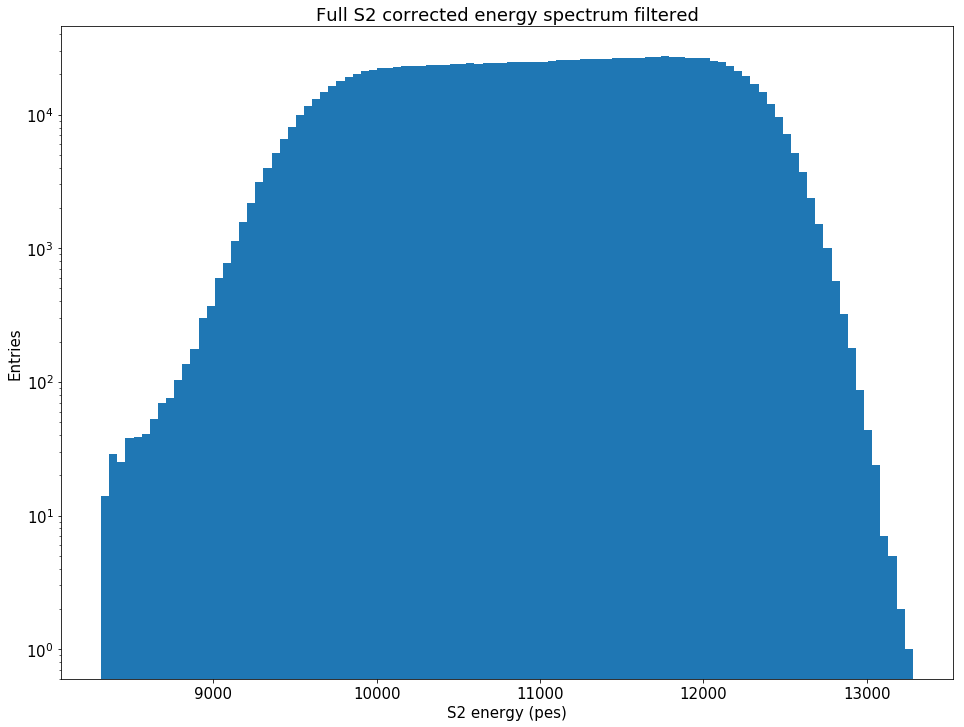

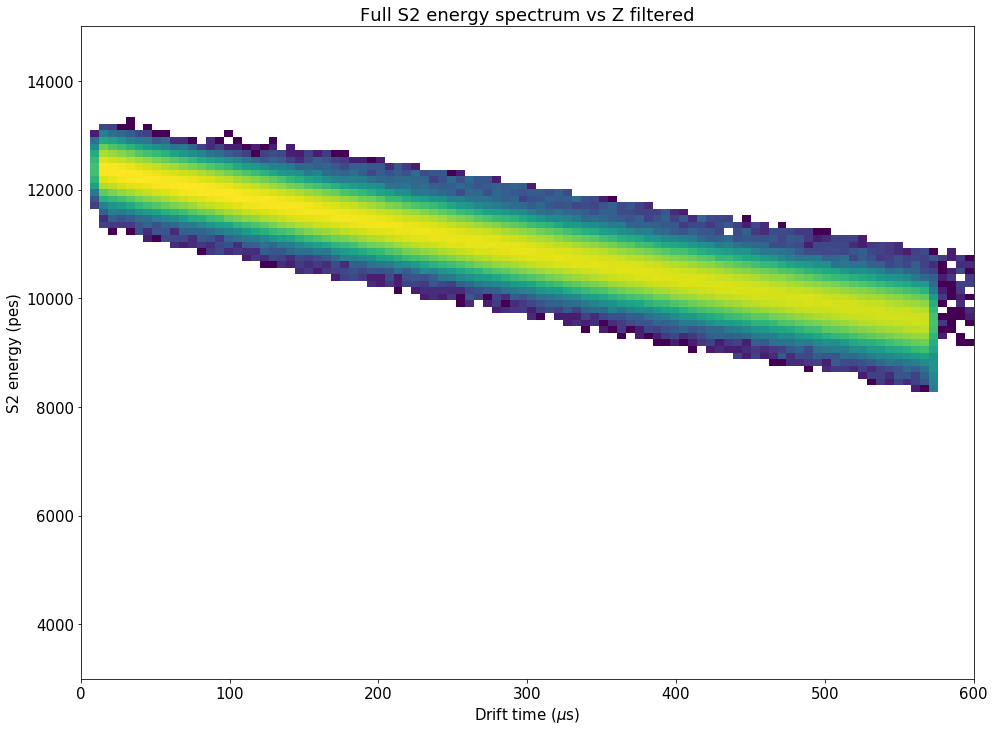

In [13]:
data  = full_filtered
Ecorr = data.S2e * XYcorrection(data.X.values, data.Y.values).value

hist2d(data.X, data.Y, (100,100), range=[XYrange,XYrange])
labels("X (mm)", "Y (mm)", "XY distribution filtered")
save("Raw_XY_filtered")

hist(data.Z, 100)
plt.yscale('log')
labels("Z (mm)", "Entries", "Z distribution filtered")
save("Raw_Z_filtered")

hist(data.time, 100)
labels("time (s)", "Entries", "T distribution filtered")
save("Raw_t_filtered")


hist(data.S1e, 50, range=[0,100])
labels("S1 energy (pes)", "Entries", "Full S1 enegry spectrum filtered")
save("Raw_S1_energy_full_filtered")


hist2d(data.Z, data.S1e, (100, 50), range=(Zrange, [0,100]))
labels("Drift time ($\mu$s)", "S1 energy (pes)", "Full S1 energy spectrum vs Z filtered")
save("Raw_S1_energy_vsZ_full_filtered")

hist(Ecorr, 100)
plt.yscale('log')
labels("S2 energy (pes)", "Entries", "Full S2 corrected energy spectrum filtered")
save("Raw_S2_energy_full_filtered")


hist2d(data.Z, Ecorr, (100, 100), range=(Zrange, Erange_raw), norm=LogNorm())
labels("Drift time ($\mu$s)", "S2 energy (pes)", "Full S2 energy spectrum vs Z filtered")
save("Raw_S2_energy_vsZ_full_filtered")


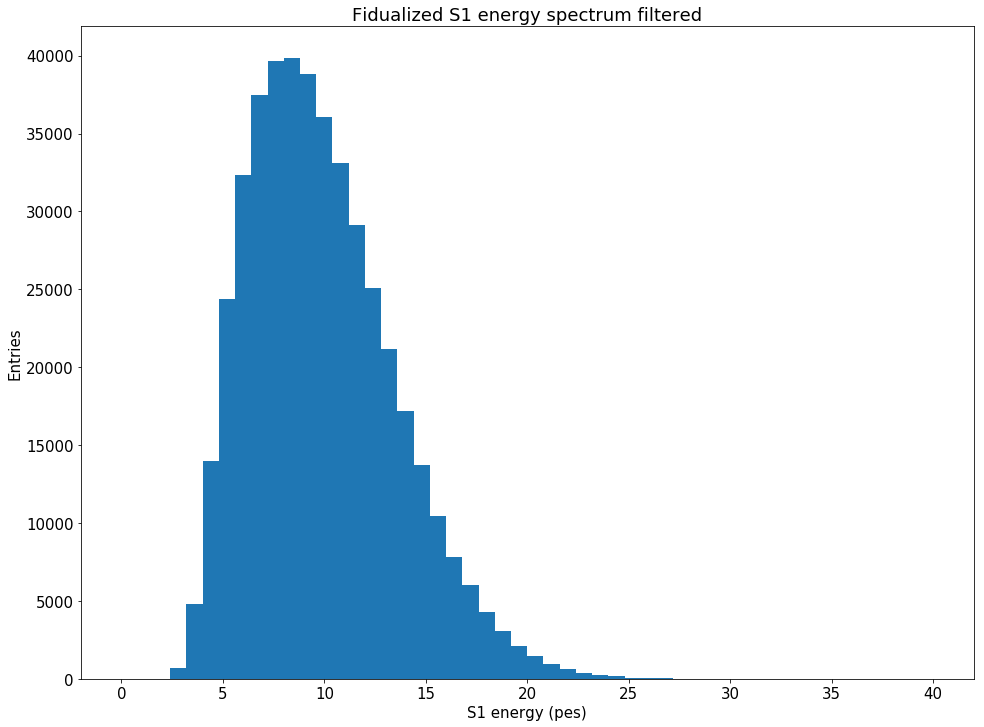

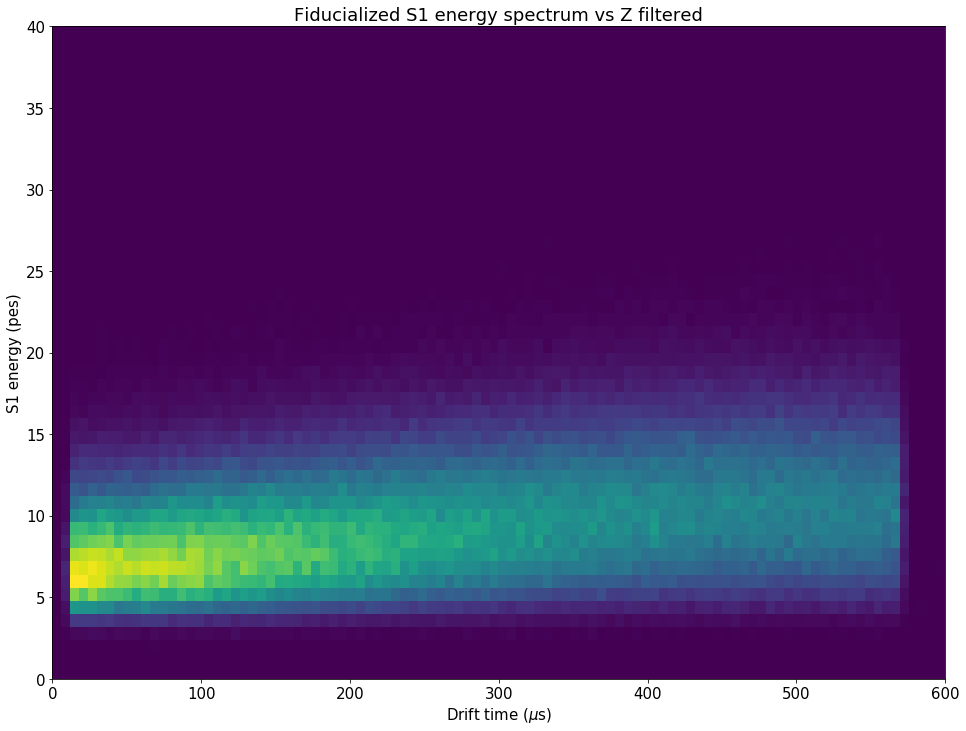

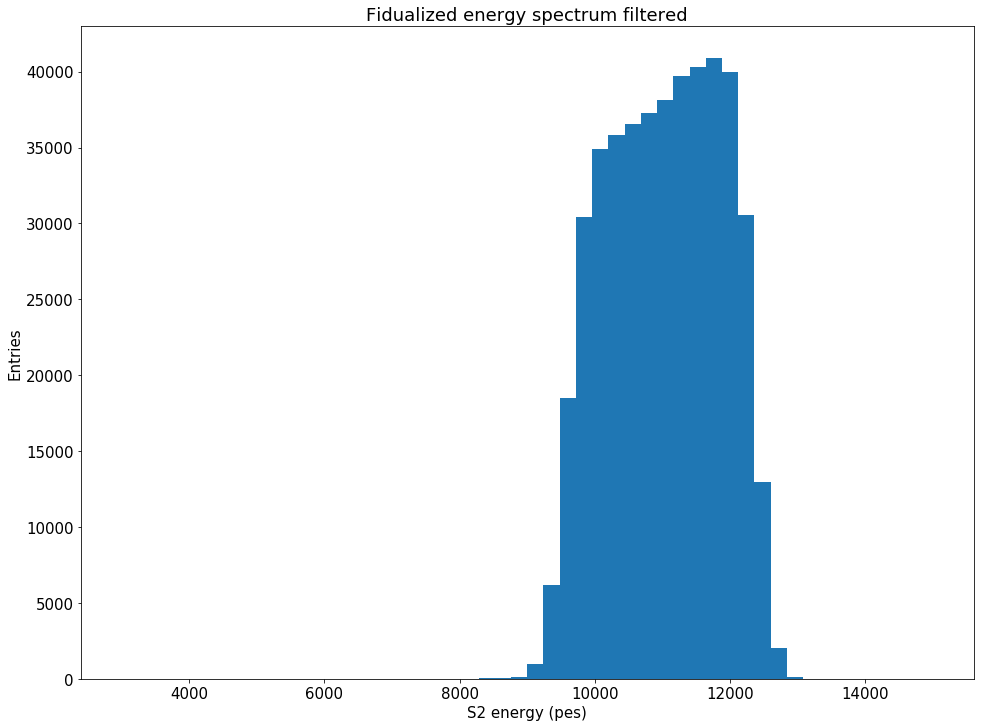

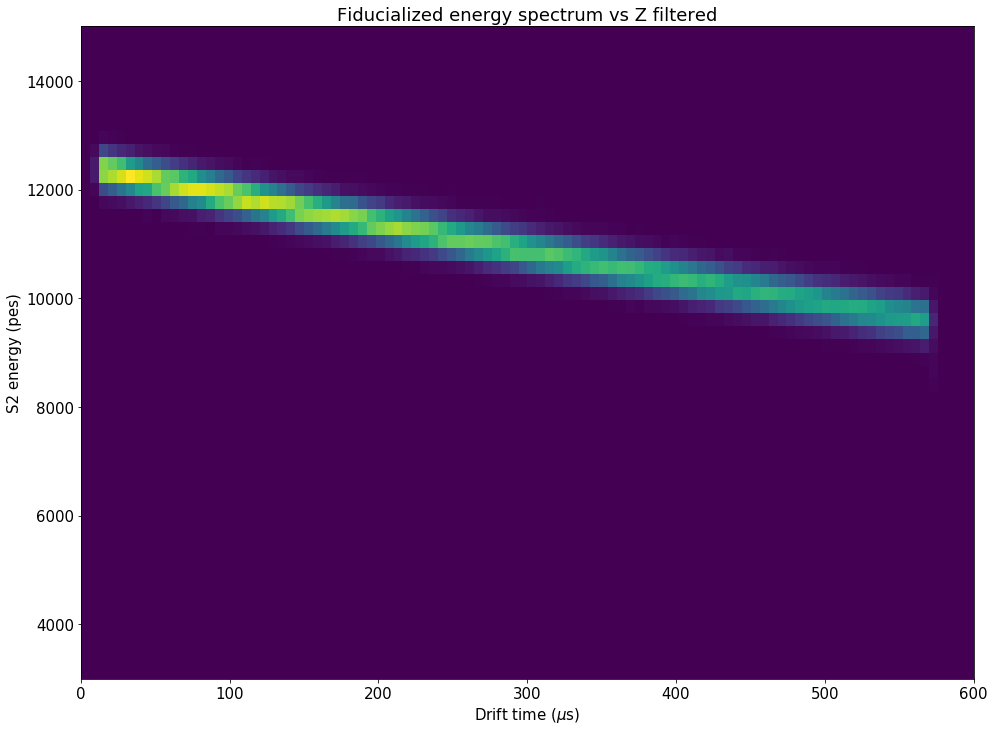

In [14]:
data  = fid_filtered
Ecorr = data.S2e * XYcorrection(data.X.values, data.Y.values).value

hist(data.S1e, 50, range=[0,40])
labels("S1 energy (pes)", "Entries", "Fidualized S1 energy spectrum filtered")
save("Raw_charge_fiducial_filtered")

hist2d(data.Z, data.S1e, (100, 50), range=(Zrange, [0,40]))
labels("Drift time ($\mu$s)", "S1 energy (pes)", "Fiducialized S1 energy spectrum vs Z filtered")
save("Raw_charge_vsZ_fiducial_filtered")


hist(Ecorr, 50, range=Erange_raw)
labels("S2 energy (pes)", "Entries", "Fidualized energy spectrum filtered")
save("Raw_energy_fiducial_filtered")


hist2d(data.Z, Ecorr, (100, 50), range=(Zrange, Erange_raw))
labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z filtered")
save("Raw_energy_vsZ_fiducial_filtered")


## Computation

In [15]:
data = fid_filtered

Zbins = np.linspace(*Z_fiducial, nslices)
Zcorr = corrf.LifetimeCorrection(-Ltguess, E0guess)


Z_drift_data = []
sigma        = []
for i in range(len(Zbins)-1):
    zpos    = np.mean([Zbins[i], Zbins[i+1]])
    data_   = data[coref.in_range(data.Z.values, Zbins[i], Zbins[i+1])]
    E_zcorr = data_.S2e.values * XYcorrection(data_.X.values, data_.Y.values).value
    
    y, x    = np.histogram(E_zcorr, 50, range=Erange_raw)
    x       = shift_to_bin_centers(x)
    seed = 1e4,  E0guess*Zcorr(zpos).value, 200 
    f    = fitf.fit(fitf.gauss, x, y, seed, fit_range=Erange_raw)
    Z_drift_data.append([f.values[1],f.errors[1]])
    sigma.append(f.values[2])


Energy at z=0 = 12453.9 +- 0.1
Lifetime      = 2184.125 +- 0.110
Chi2          = 526.91          


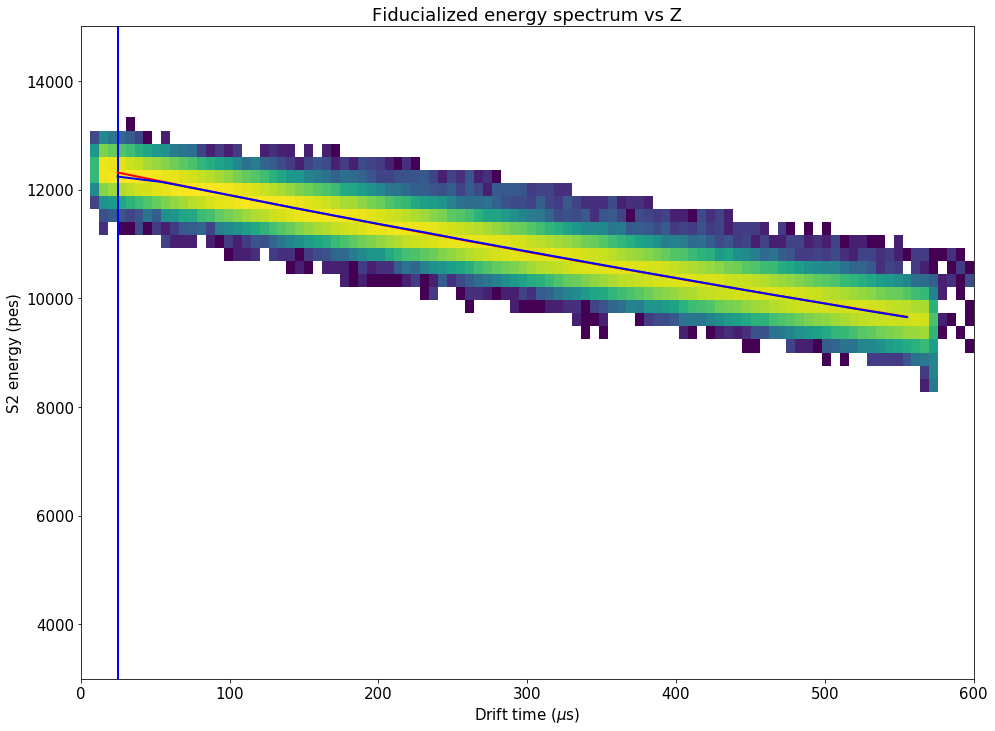

In [16]:
E_z = data.S2e * XYcorrection(data.X.values, data.Y.values).value
hist2d(data.Z, E_z, (100, 50), range=(Zrange, Erange_raw), norm=LogNorm())

x, y, u_y, sigma = map(np.array, [Zbins, *zip(*Z_drift_data), sigma])
x = shift_to_bin_centers(x)

plt.errorbar(x, y, yerr=u_y, fmt='b', linewidth=2)

seed = E0guess, -Ltguess
f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Z_fiducial, sigma=u_y)

E0mean, Ltmean = f.values 

plt.plot(x, f.fn(x), c='r', linewidth=2)
print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
print("Lifetime      = {:.3f} +- {:.3f}".format(-f.values[1], f.errors[1]))
print("Chi2          = {:.2f}          ".format(f.chi2))

labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")
save("S2energyvsZ_fiducial")

# time profile

In [17]:
Zbins=500
data = full_filtered
data = data.sort_values('event')

tstart = data.time.values[ 0]
tfinal = data.time.values[-1]

ntimebins = int( np.floor( ( tfinal - tstart) / nStimeprofile) )
ntimebins = np.max([ntimebins, 1])

tbins = np.linspace( tstart, tfinal, ntimebins+1)
time, lt, elt, e0, ee0, efb, eefb, chi2, s1e, es1e, s2e, es2e = [], [], [], [], [], [], [], [], [], [], [], []

for t in range(ntimebins):
    data_time = data[coref.in_range(data.time, tbins[t], tbins[t+1])]
    Zbins = np.linspace(*Z_fiducial, nslices)
    Zcorr = corrf.LifetimeCorrection(Ltmean, E0mean)
    Z_drift_data = []
    for i in range(len(Zbins)-1):
        zpos    = np.mean([Zbins[i], Zbins[i+1]])
        data_   = data_time[coref.in_range(data_time.Z.values, Zbins[i], Zbins[i+1])]
        E_zcorr = data_.S2e.values * XYcorrection(data_.X.values, data_.Y.values).value

        y, x    = np.histogram(E_zcorr, 50, range=Erange_raw)
        x       = shift_to_bin_centers(x)
        seed = 1e3,  12e3*Zcorr(zpos).value, 200

        f    = fitf.fit(fitf.gauss, x, y, seed, fit_range=Erange_raw, sigma=poisson_sigma(y))
        #plt.figure()
        #plt.errorbar(x,y)
        #plt.plot(x, fitf.gauss(x,*f.values))
        Z_drift_data.append([f.values[1],f.errors[1]])

    x, y, u_y = map(np.array, [Zbins, *zip(*Z_drift_data)])
    u_y[np.isnan(u_y)] = 9e9
    x = shift_to_bin_centers(x)
    
    
    seed = 12e3, Ltmean
    f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Z_fiducial, sigma=u_y)
    #plt.figure()
    #plt.hist2d(data_time.Z, data_time.S2e*XYcorrection(data_time.X.values, data_time.Y.values).value,
    #           (100, 50), range=(Zrange, [8e3, 14e3]), norm=LogNorm())
    #print(u_y)
    #plt.errorbar(x,y,u_y)
    #plt.plot(x, fitf.expo(x,*f.values))
    time.append(np.mean([tbins[t],tbins[t+1]]))
    lt  .append(-f.values[1])
    elt .append(f.errors[1])
    efb .append(Z_drift_data[0][0])
    eefb.append(Z_drift_data[0][1])
    e0  .append(f.values[0])
    ee0 .append(f.errors[0])
    chi2.append(f.chi2)
    s1e .append(np.mean(data_time.S1e))
    es1e.append((np.var(data_time.S1e)/len(data_time.S1e))**0.5)
    s2e .append(np.mean(data_time.S2e))
    es2e.append((np.var(data_time.S2e)/len(data_time.S2e))**0.5)

rate = np.histogram(data.time, ntimebins)[0]


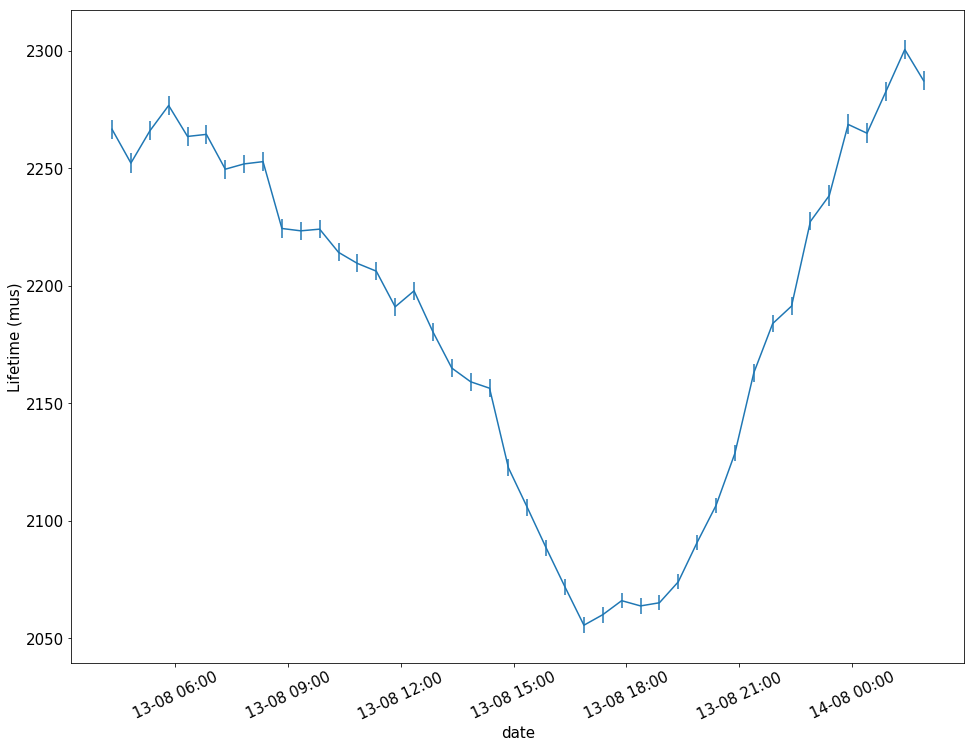

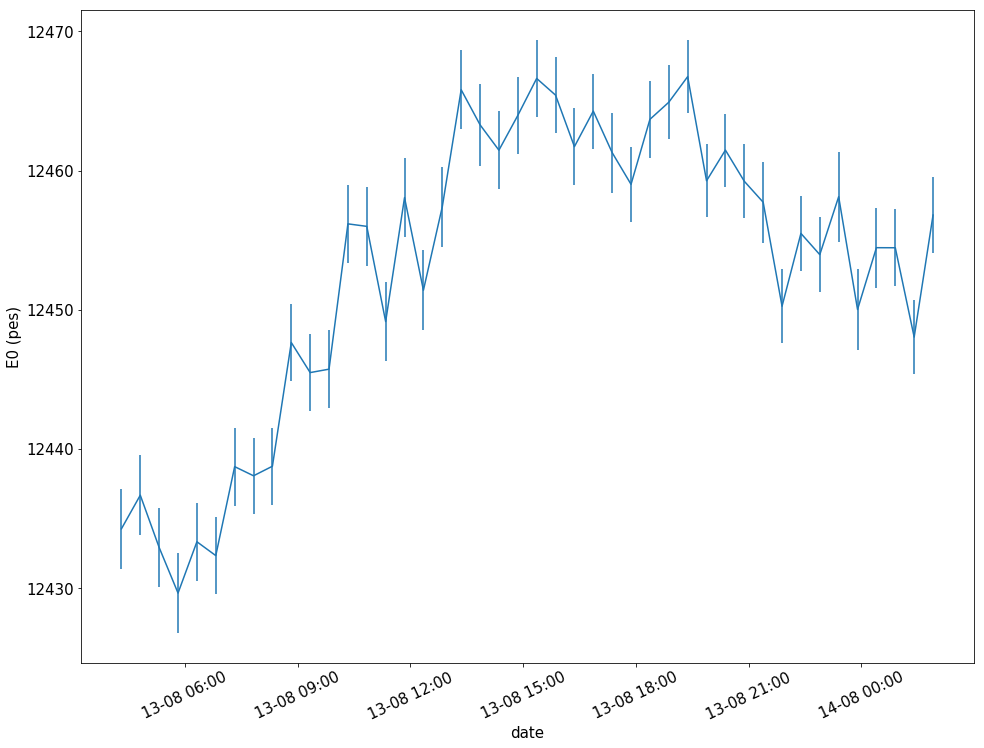

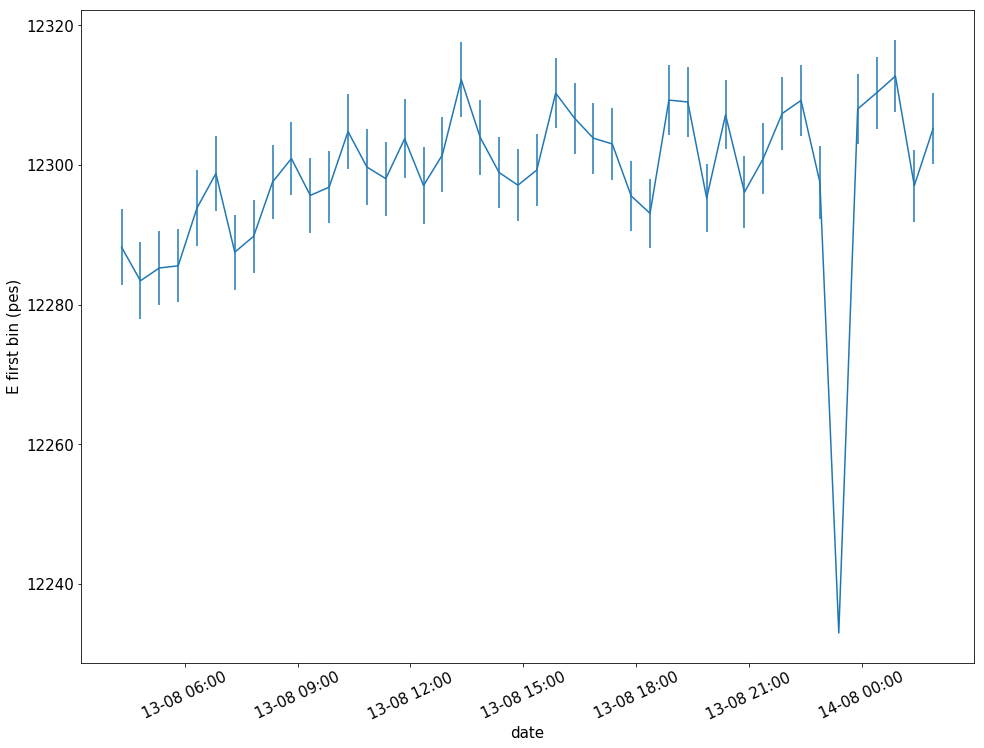

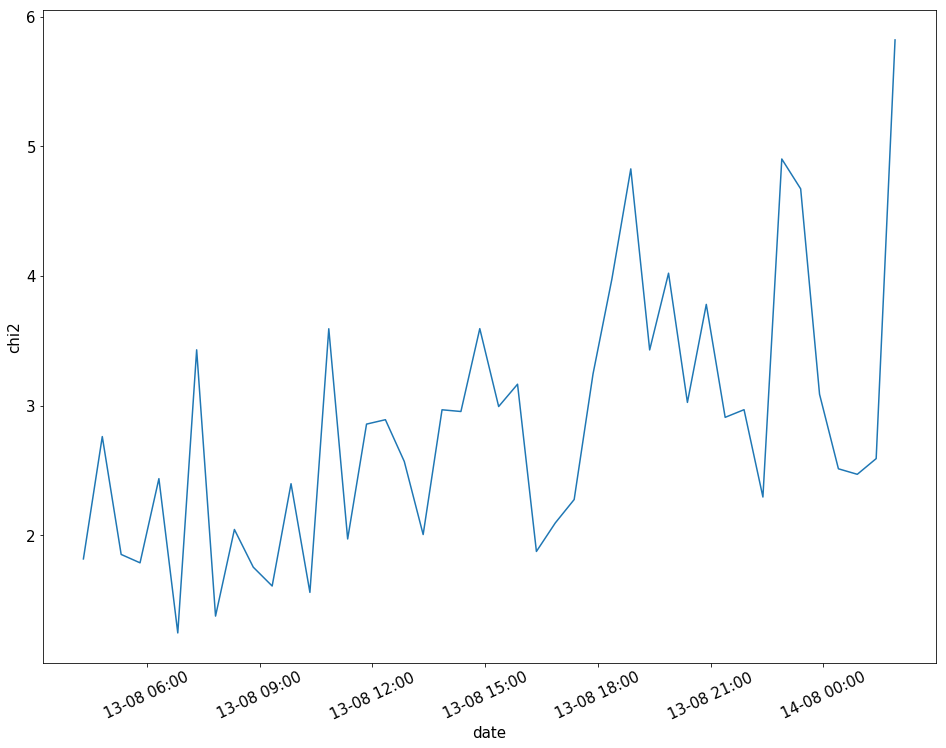

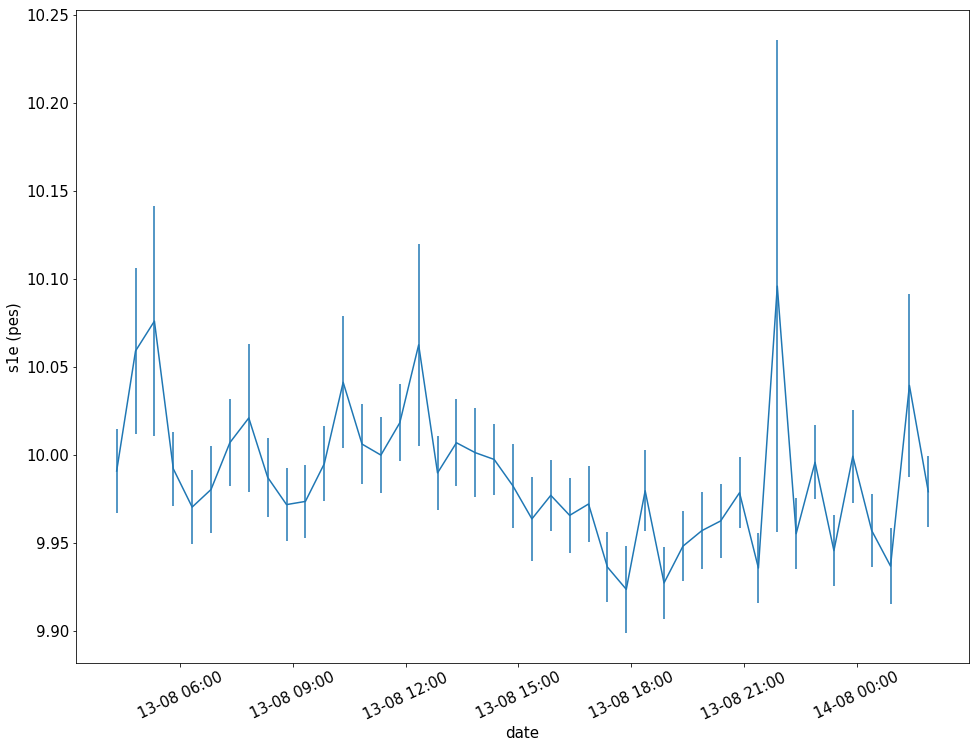

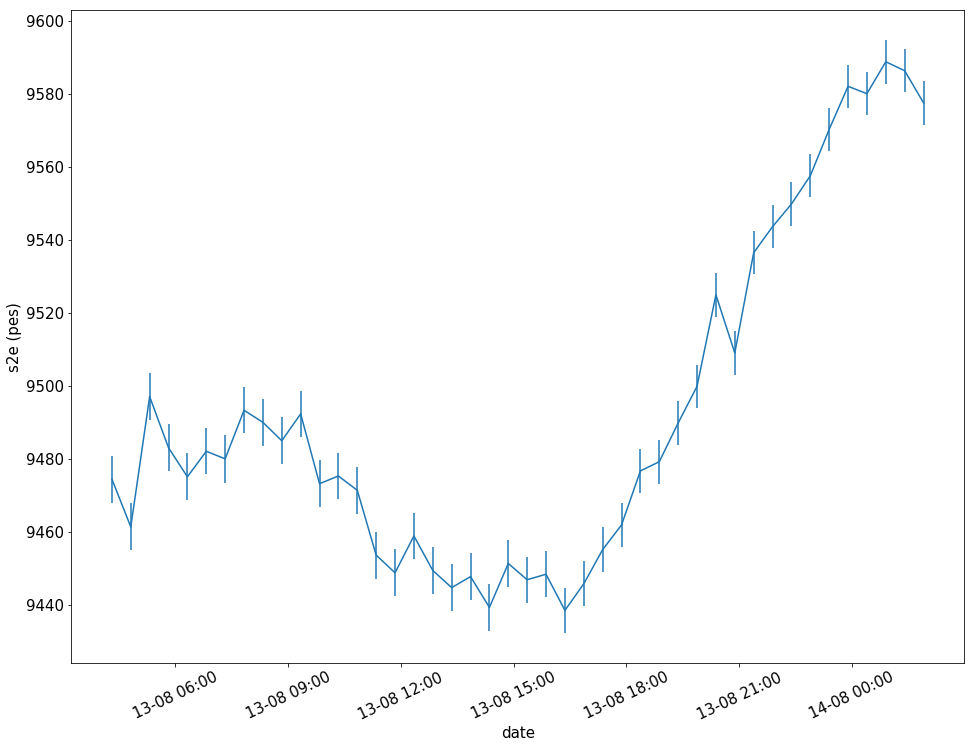

In [18]:
time_ = list(map(datetime.datetime.fromtimestamp, time))

plt.figure()
ax=plt.gca()
xfmt = md.DateFormatter('%d-%m %H:%M')
ax.xaxis.set_major_formatter(xfmt)    

#plt.MultipleLocator()
plt.errorbar(time_, lt, elt)
plt.xlabel('date')
plt.ylabel('Lifetime (mus)')
plt.xticks( rotation=25 )
save("LifetimevsDate")


plt.figure()
ax=plt.gca()
xfmt = md.DateFormatter('%d-%m %H:%M')
ax.xaxis.set_major_formatter(xfmt)  

plt.errorbar(time_, e0, ee0)
plt.xlabel('date')
plt.ylabel('E0 (pes)')
plt.xticks( rotation=25 )
save("Ez0vsDate")


plt.figure()
ax=plt.gca()
xfmt = md.DateFormatter('%d-%m %H:%M')
ax.xaxis.set_major_formatter(xfmt)  

plt.errorbar(time_, efb, eefb)
plt.xlabel('date')
plt.ylabel('E first bin (pes)')
plt.xticks( rotation=25 )
save("EfirstbinvsDate")


plt.figure()
ax=plt.gca()
xfmt = md.DateFormatter('%d-%m %H:%M')
ax.xaxis.set_major_formatter(xfmt)  

plt.errorbar(time_, chi2, 0)
plt.xlabel('date')
plt.ylabel('chi2')
plt.xticks( rotation=25 )
save("Chi2vsDate")

plt.figure()
ax=plt.gca()
xfmt = md.DateFormatter('%d-%m %H:%M')
ax.xaxis.set_major_formatter(xfmt)  

plt.errorbar(time_, s1e, es1e)
plt.xlabel('date')
plt.ylabel('s1e (pes)')
plt.xticks( rotation=25 )
save("S1evsDate")

plt.figure()
ax=plt.gca()
xfmt = md.DateFormatter('%d-%m %H:%M')
ax.xaxis.set_major_formatter(xfmt)  

plt.errorbar(time_, s2e, es2e)
plt.xlabel('date')
plt.ylabel('s2e (pes)')
plt.xticks( rotation=25 )
save("S2evsDate")

In [19]:
np.savetxt('last_value.txt ',np.array([[time[-1], lt[-1], elt[-1]]]))

# Drift velocity

Max drift length = 571.156 +- 0.052
Drift velocity   = 0.92829 +- 0.00008


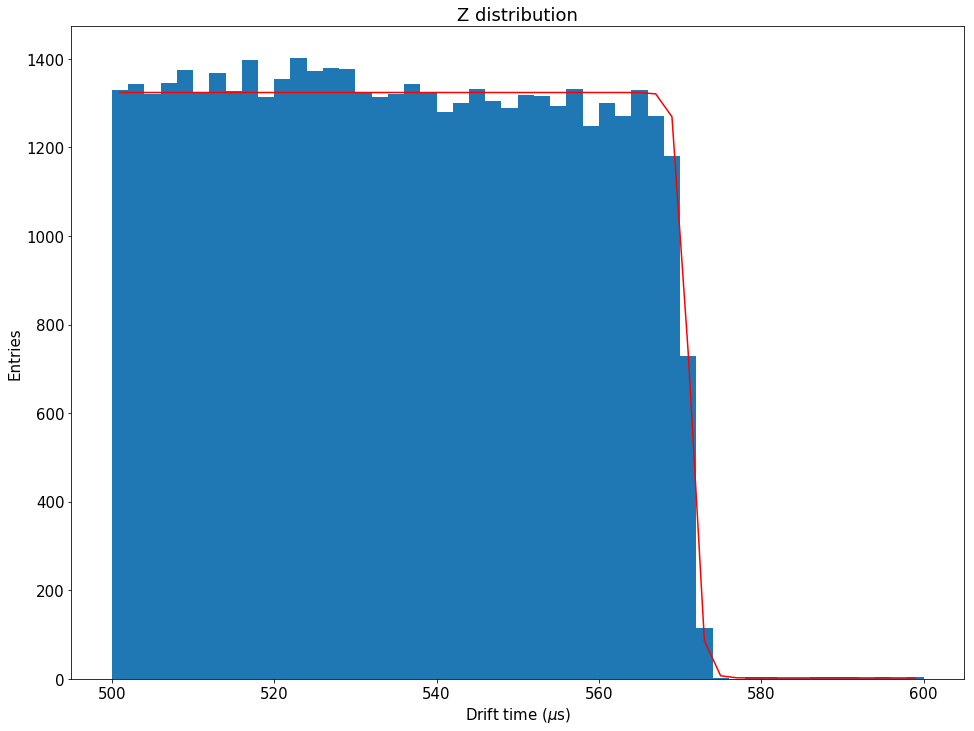

In [20]:
data = fid_filtered
y, x, _ = hist(data.Z, 50, Zrange_DV)
 
sigmoid  = lambda x, A, B, C, D: A/(1 + np.exp(-C*(x-B))) + D
seed     = np.max(y), np.mean(Zrange_DV), np.diff(Zrange_DV)[0]/100, np.min(y)
f        = fitf.fit(sigmoid, x, y, seed, sigma=poisson_sigma(y), fit_range=Zrange_DV)

dt_mean   = f.values[1]
edt_mean  = f.errors[1]
dv_mean   = 530.2/f.values[1]
u_dv_mean =  dv_mean/f.values[1] * f.errors[1]

plt.plot(x, f.fn(x), fitOpt)

labels("Drift time ($\mu$s)", "Entries", "Z distribution")
print("Max drift length = {:.3f} +- {:.3f}".format(f.values[1], f.errors[1]))
print("Drift velocity   = {:.5f} +- {:.5f}".format(dv_mean, u_dv_mean))
save("Drift_velocity")

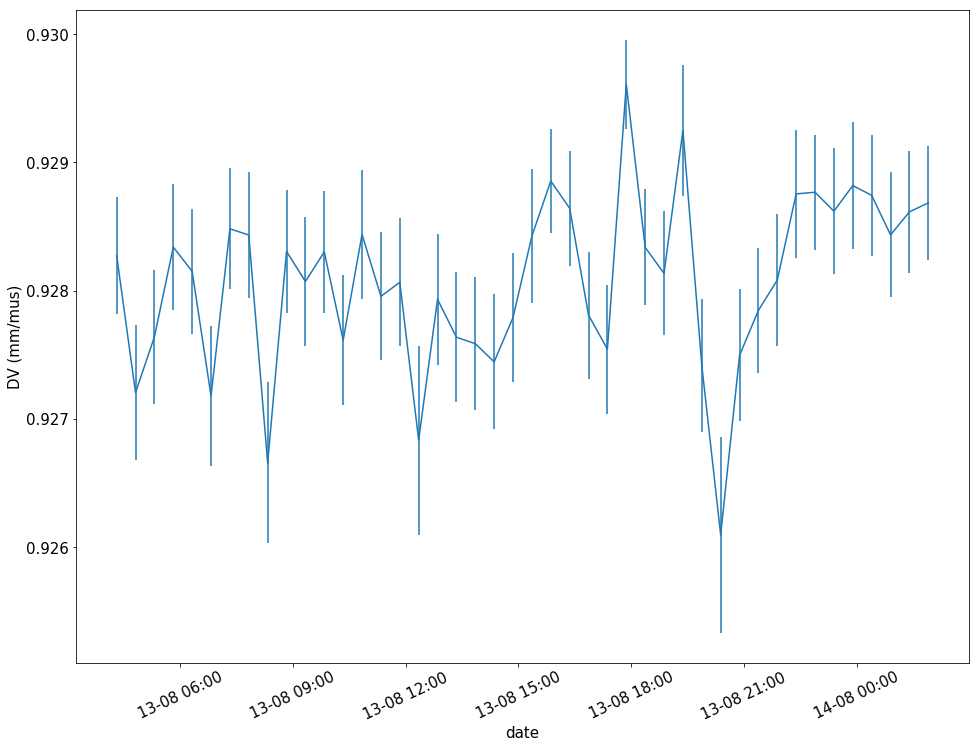

In [21]:
sigmoid   = lambda x, A, B, C, D: A/(1 + np.exp(-C*(x-B))) + D

data = full
data = data.sort_values('event')

tstart = data.time.values[ 0]
tfinal = data.time.values[-1]

ntimebins = int( np.floor( ( tfinal - tstart) / nStimeprofile) )
ntimebins = np.max([ntimebins, 1])

tbins = np.linspace( tstart, tfinal, ntimebins+1)
time, dv, edv = [], [], []

for t in range(ntimebins):
    data_time = data[coref.in_range(data.time, tbins[t], tbins[t+1])]
    y, x      =  np.histogram(data_time.Z, 25, Zrange_DV)
    x = shift_to_bin_centers(x)
   
    seed      = 200, dt_mean, np.diff(Zrange_DV)[0]/100, 0
    f         = fitf.fit(sigmoid, x, y, seed, sigma=poisson_sigma(y), fit_range=Zrange_DV)

    dv_   = 530.2/f.values[1]
    u_dv =  dv_/f.values[1] * f.errors[1]

    time.append(np.mean([tbins[t],tbins[t+1]]))
    dv  .append(dv_)
    edv .append(u_dv)


time_ = list(map(datetime.datetime.fromtimestamp, time))

plt.figure()
ax=plt.gca()
xfmt = md.DateFormatter('%d-%m %H:%M')
ax.xaxis.set_major_formatter(xfmt)    
plt.errorbar(time_, dv, edv)
plt.xlabel('date')
plt.ylabel('DV (mm/mus)')
plt.xticks( rotation=25 )
save("DriftVelocityvsDate")


In [22]:
#data_ = full_filtered
#data_ = data_[coref.in_range(data_.Z, 0, 100)]
#ev    = data_.event
#np.save("EvtID_z_0_100_{0}".format(run_number), ev)

# Saving parameters

In [23]:
output_dir

'/Users/brais/Documents/NEXT/Datos/Kr_lt/6283_/'

In [24]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [25]:
class parameters(tb.IsDescription):
    time = tb.  Int64Col()
    rate = tb.  Int64Col()
    lt   = tb.Float64Col()
    elt  = tb.Float64Col()
    e0   = tb.Float64Col()
    ee0  = tb.Float64Col()
    s1e  = tb.Float64Col()
    es1e = tb.Float64Col()
    s2e  = tb.Float64Col()
    es2e = tb.Float64Col()    
    dv   = tb.Float64Col()
    edv  = tb.Float64Col()

    
    
with tb.open_file(output_file, mode="w", title="Run_Parameters") as h5out:
    group = h5out.create_group("/", 'parameters', 'Parameters')
    table = h5out.create_table(group, "test", parameters, 'test')
    row = table.row
    for i in range(len(time)):
        row['time'] = time[i]
        row['rate'] = rate[i]
        row['lt'  ] = lt  [i]
        row['elt' ] = elt [i]
        row['e0'  ] = e0  [i]
        row['ee0' ] = ee0 [i]
        row['s1e' ] = s1e [i]
        row['es1e'] = es1e[i]
        row['s2e' ] = s2e [i]
        row['es2e'] = es2e[i]
        row['dv'  ] = dv  [i]
        row['edv' ] = edv [i]
        row.append()
        
    h5out.flush()

    
    #row = table.row
    #row["time"] = time
    #...
    #row.append()

In [26]:
f = tb.open_file(output_file, mode="r")

In [27]:
f

File(filename=/Users/brais/Documents/NEXT/Datos/Kr_lt/6283_/Time_evolution_6283.h5, title='Run_Parameters', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) 'Run_Parameters'
/parameters (Group) 'Parameters'
/parameters/test (Table(44,)) 'test'
  description := {
  "dv": Float64Col(shape=(), dflt=0.0, pos=0),
  "e0": Float64Col(shape=(), dflt=0.0, pos=1),
  "edv": Float64Col(shape=(), dflt=0.0, pos=2),
  "ee0": Float64Col(shape=(), dflt=0.0, pos=3),
  "elt": Float64Col(shape=(), dflt=0.0, pos=4),
  "es1e": Float64Col(shape=(), dflt=0.0, pos=5),
  "es2e": Float64Col(shape=(), dflt=0.0, pos=6),
  "lt": Float64Col(shape=(), dflt=0.0, pos=7),
  "rate": Int64Col(shape=(), dflt=0, pos=8),
  "s1e": Float64Col(shape=(), dflt=0.0, pos=9),
  "s2e": Float64Col(shape=(), dflt=0.0, pos=10),
  "time": Int64Col(shape=(), dflt=0, pos=11)}
  byteorder := 'little'
  chunkshape := (682,)

In [28]:
a = pd.DataFrame.from_records(getattr(getattr(f.root, "parameters"),"test").read())
a

,dv,e0,edv,ee0,elt,es1e,es2e,lt,rate,s1e,s2e,time
0,0.928275,12434.267219,0.000456,2.895800,4.130569,0.024056,6.428527,2266.678217,30593,9.990724,9474.510284,1534151927
1,0.927204,12436.684662,0.000526,2.885466,4.073459,0.047143,6.457356,2252.291488,30457,10.058974,9461.397026,1534153735
2,0.927640,12432.928348,0.000523,2.817767,4.043318,0.065276,6.438891,2265.949282,30475,10.075942,9497.107190,1534155543
3,0.928340,12429.652883,0.000488,2.863082,4.121325,0.021018,6.428815,2276.804335,30490,9.992015,9483.083926,1534157350
4,0.928150,12433.339291,0.000485,2.807818,4.071589,0.021103,6.414270,2263.620279,30648,9.970233,9475.122467,1534159158
5,0.927178,12432.344861,0.000544,2.762251,4.007237,0.024994,6.334933,2264.503302,30991,9.980236,9482.124909,1534160966
6,0.928482,12438.736130,0.000473,2.793706,4.000120,0.024606,6.490164,2249.675482,30322,10.006890,9480.050163,1534162774
7,0.928434,12438.078860,0.000492,2.749620,3.912720,0.042254,6.356940,2251.935109,30992,10.020891,9493.357189,1534164582
8,0.926657,12438.764992,0.000629,2.780679,3.994099,0.022442,6.405536,2252.896178,30491,9.987154,9490.054838,1534166390
9,0.928306,12447.651019,0.000480,2.763555,3.873632,0.020893,6.417928,2224.443009,31177,9.971652,9485.007651,1534168197


In [29]:
f.close()